In [ ]:
import numpy as np
from numpy import matlib
import os
import cv2
import scipy.signal as signal
import scipy
from google.colab.patches import cv2_imshow


In [ ]:
def lowpass_order(f_pass, f_stop, dpass_dB, dstop_dB, fsamp = 2):
    """
    Optimal FIR (equal ripple) Lowpass Order Determination
    
    Text reference: Ifeachor, Digital Signal Processing a Practical Approach, 
    second edition, Prentice Hall, 2002.
    Journal paper reference: Herriman et al., Practical Design Rules for Optimum
    Finite Imulse Response Digitl Filters, Bell Syst. Tech. J., vol 52, pp. 
    769-799, July-Aug., 1973.IEEE, 1973.
    """
    dpass = 1 - 10**(-dpass_dB/20)
    dstop = 10**(-dstop_dB/20)
    Df = (f_stop - f_pass)/fsamp
    a1 = 5.309e-3
    a2 = 7.114e-2
    a3 = -4.761e-1
    a4 = -2.66e-3
    a5 = -5.941e-1
    a6 = -4.278e-1
    
    Dinf = np.log10(dstop)*(a1*np.log10(dpass)**2 + a2*np.log10(dpass) + a3) \
           + (a4*np.log10(dpass)**2 + a5*np.log10(dpass) + a6)
    f = 11.01217 + 0.51244*(np.log10(dpass) - np.log10(dstop))
    N = Dinf/Df - f*Df + 1
    ff = 2*np.array([0, f_pass, f_stop, fsamp/2])/fsamp
    aa = np.array([1, 1, 0, 0])
    wts = np.array([1.0, dpass/dstop])
    return int(N), ff, aa, wts

In [ ]:
def fir_remez_lpf(f_pass, f_stop, d_pass, d_stop, fs = 20.0, N_bump=5, status = True):
    """
    Design an FIR lowpass filter using remez with order
    determination. The filter order is determined based on 
    f_pass Hz, fstop Hz, and the desired passband ripple 
    d_pass dB and stopband attenuation d_stop dB all 
    relative to a sampling rate of fs Hz.

    Mark Wickert October 2016, updated October 2018
    """
    n, ff, aa, wts = lowpass_order(f_pass, f_stop, d_pass, d_stop, fsamp=fs)
    # Bump up the order by N_bump to bring down the final d_pass & d_stop
    N_taps = n
    N_taps += N_bump
    b = signal.remez(N_taps, ff, aa[0::2], wts,Hz=2)
    #if status:
        #print('Remez filter taps = %d.' % N_taps)
    return b

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
import shutil
import os
path = '/content/gdrive/My Drive/H8_M55_S48 PP213-1' ## Add path to videos with mcam data here
os.chdir('/content/gdrive/My Drive/')
shutil.make_archive('H8_M55_S48 PP213-1_ZIPPED','zip',path)

ValueError: ignored

In [ ]:
os.chdir('/content/gdrive/My Drive/')
shutil.make_archive('H8_M55_S48 PP213-1','zip',path)

Paths and Directories

In [ ]:
##Paths and Directories
import shutil
path = '/content/gdrive/My Drive/H8_M55_S48 PP213-1' ## Add path to videos with mcam data here
savepath = path + '/Cleaned_msCam'
cleaned_path = '/root/Cleaned_Data'
path_to_setting_and_notes = path +'/settings_and_notes.dat'
path_to_timestamp = path +'/timestamp.dat'
# if len(os.listdir(savepath)) == 0:
try:
  os.mkdir(cleaned_path)
  os.mkdir(cleaned_path + '/msCam')
  os.mkdir(cleaned_path + '/Cleaned_msCam')
  os.mkdir(savepath)
  shutil.copyfile(path_to_setting_and_notes, savepath + '/settings_and_notes.dat')
  shutil.copyfile(path_to_timestamp, savepath + '/timestamp.dat')
 
except:
  shutil.rmtree(cleaned_path)
  os.mkdir(cleaned_path)
  os.mkdir(cleaned_path + '/msCam')
  os.mkdir(cleaned_path + '/Cleaned_msCam')
  try:
    os.mkdir(savepath)
  except:
    pass
  shutil.copyfile(path_to_setting_and_notes, savepath + '/settings_and_notes.dat')
  shutil.copyfile(path_to_timestamp, savepath + '/timestamp.dat')
# else:
#   print('Setting and Timestamp Files inside the folder!')


In [ ]:
import re
##Function for Alphanumerically ordering file list
def sorted_nicely( l ):
    """ Sorts the given iterable in the way that is expected.
 
    Required arguments:
    l -- The iterable to be sorted.
 
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

In [ ]:
###Exports the Cleaned Videos to the Specified Drive Folder
filelist = os.listdir(path)
filelist = sorted_nicely(filelist)
filelist = [x for x in filelist if x.startswith('msCam')] 
for infile in sorted_nicely(filelist):
  if(str(infile).startswith('msCam')):
    shutil.copy2(path + '/' + str(infile), cleaned_path + '/msCam/' + str(infile))
    print('Cleaning:' + str(infile))
    video = cv2.VideoCapture(cleaned_path + '/msCam/' + str(infile))
    fps = video.get(cv2.CAP_PROP_FPS)
    cleaned_video = cleaned_path + '/Cleaned_msCam' + '/' + str(infile)
    cap1 = cv2.VideoWriter(cleaned_video,cv2.VideoWriter_fourcc('M','J','P','G'),fps,(int(video.get(cv2.CAP_PROP_FRAME_WIDTH)),int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))))
    
    while(video.isOpened()):
      ret,frame = video.read()
      if(ret):
        ####Method 1
        d = fir_remez_lpf(0.01,1,1,50)
        b = np.mean(frame,1)
        bs = scipy.signal.filtfilt(d,1,b,axis = 0)
        ttemp = bs - b
        ttemp = np.reshape(ttemp,(ttemp.shape[0],1,ttemp.shape[1]))
        ttempp = np.tile(ttemp,(1,frame.shape[1],1))
        iimg = (frame) + ttempp

        ####Not Necessarily Needed
        c = np.mean(iimg,0)
        cs = scipy.signal.filtfilt(d,1,c,axis = 0)
        ttemp = cs - c
        ttemp = np.reshape(ttemp,(1,ttemp.shape[0],ttemp.shape[1]))
        ttempp = np.tile(ttemp,(frame.shape[0],1,1))
        frame_C = (iimg) + ttempp
        frame_C = frame_C-(np.mean(frame_C[:]-90))
        frame_fft_C = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(frame_C)))
        #cv2_imshow(np.abs(frame_C))
        ##Method 2
        frame_fft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(frame)))
        frame_fft[260-2:260+2,404-2:404+2]=0
        frame_fft[348-2:348+2,404-2:404+2]=0

        frame_fft[239-1:239+1,404-2:404+2]=0
        frame_fft[369-1:369+1,404-2:404+2]=0

        frame_fft[282-2:282+2,404-2:404+2]=0
        frame_fft[326-2:326+2,404-2:404+2]=0

        frame_fft[0:59,404-5:404+5]=0
        frame_fft[607-60+1:607,404-5:404+5]=0

        frame_c2=np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(frame_fft)))
        # cv2_imshow(np.abs(frame_c2).astype(np.uint8))
        cap1.write((frame_C).astype(np.uint8))
      else:
        video.release()
        cap1.release()
    shutil.copyfile(cleaned_video,savepath + '/' + str(infile))
    print('Wrote Cleaned File to Gdrive')
cv2.destroyAllWindows()

OSError: ignored

### **PIMPIN Portion**

In [ ]:
path_to_analyze = savepath
analyze_behavior = True
path_to_DLC_model = '' # Change yours here. Should be a zip file containing your full, trained model
spatial_downsampling = 2 # Drastically speeds up processing. 2-3 recommended
isnonrigid = False
# alert_gmail = '' # You can leave your Gmail adress to be notified when your analysis is done
# alert_gmail_password = '' # Password to your Gmail account
try:
  os.mkdir(path_to_results)
except:
  pass
print('Parameters saved. Ready to start analyzing')

Parameters saved. Ready to start analyzing


### **Install and Import Dependencies**

In [ ]:
from datetime import datetime
import scipy.io as sio
import re
import os
import h5py
import csv
import tensorflow as tf
import time
import logging
import zipfile
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default')
import numpy as np
from moviepy.editor import *
import smtplib

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1048576/45929032 bytes (2.3%)3915776/45929032 bytes (8.5%)8208384/45929032 bytes (17.9%)12394496/45929032 bytes (27.0%)16637952/45929032 bytes (36.2%)20840448/45929032 bytes (45.4%)25124864/45929032 bytes (54.7%)29122560/45929032 bytes (63.4%)33366016/45929032 bytes (72.6%)37552128/45929032 bytes (81.8%)41787392/45929032 bytes (91.0%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root/.im

In [ ]:
# Install CaImAn
#!git clone https://github.com/flatironinstitute/CaImAn.git
!git clone https://github.com/etterguillaume/CaImAn.git
%cd '/content/CaImAn/'
!pip install -e .

!pip install tifffile
!pip install ipyparallel
!pip install peakutils

%cd '/content/CaImAn/'
!python caimanmanager.py install --inplace

!export MKL_NUM_THREADS=1
!export OPENBLAS_NUM_THREADS=1

# This is for GPU accelaration
!pip install pycuda
!pip install scikit-cuda

import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import params as params
import peakutils

Cloning into 'CaImAn'...
remote: Enumerating objects: 18836, done.
remote: Total 18836 (delta 0), reused 0 (delta 0), pack-reused 18836
Receiving objects: 100% (18836/18836), 459.78 MiB | 29.55 MiB/s, done.
Resolving deltas: 100% (12561/12561), done.
Checking out files: 100% (276/276), done.
/content/CaImAn
Obtaining file:///content/CaImAn
  Running setup.py develop for caiman
     |████████████████████████████████| 204kB 9.0MB/s 
/content/CaImAn
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
Installed /root/caiman_data
     |████████████████████████████████| 1.6MB 8.3MB/s 
     |██████████████████████████████

### **Get information from the Experiment**

In [ ]:
now = datetime.now()
analysis_time = now.strftime("%Y-%m-%d %H:%M") # This is to register when the analysis was performed
print('Analysis started on ' + analysis_time)

analysis_start = time.time() # This is to register the time spent analyzing

# # Open dat file here 
# try:
#   #metadata, res = dbx.files_download(path_to_analyze + '/' + 'settings_and_notes.dat')
#   f = open(path_to_analyze + '/' + 'settings_and_notes.dat','wb')
#   f.write(res.content)
#   f.close
# except FileExistsError:
#   print('Error: settings_and_notes.dat could not be found')

with open(path_to_analyze + '/' + 'settings_and_notes.dat') as f:
  for i, line in enumerate(f):
    if i == 0:
      line = str(f.readline())
      line = line.split('\t')
      experimentName = line[0]
      
print('Name of the experiment to analyze: ' + experimentName)

dirExperimentName = path + '/' + experimentName
 
try:
    # Create target Directory
    os.mkdir(dirExperimentName)
    print("Directory " , dirExperimentName ,  " Created") 
except FileExistsError:
    print("Directory " , dirExperimentName ,  " already exists")

Analysis started on 2020-10-09 06:22
Name of the experiment to analyze: PP213-1
Directory  /content/gdrive/My Drive/H8_M55_S48 PP213-1/PP213-1  already exists


### **List msCam files and Sanity Check**

In [ ]:
filesList = []
msFileList = []
for file in os.listdir(path_to_analyze):
  filesList.append(file)

for i in filesList[:]:
  if i.startswith('ms') and i.endswith('.avi'):
    msFileList.append(i)
msFileList = sorted_nicely(msFileList)
print('Miniscope files in folder:')
print(msFileList)

if len(msFileList) == 0:
  print("No miniscope avi files found")

Miniscope files in folder:
['msCam1.avi', 'msCam2.avi', 'msCam3.avi', 'msCam4.avi', 'msCam5.avi', 'msCam6.avi', 'msCam7.avi', 'msCam8.avi', 'msCam9.avi', 'msCam10.avi', 'msCam11.avi', 'msCam12.avi', 'msCam13.avi', 'msCam14.avi', 'msCam15.avi', 'msCam16.avi', 'msCam17.avi', 'msCam18.avi', 'msCam19.avi', 'msCam20.avi', 'msCam21.avi', 'msCam22.avi', 'msCam23.avi', 'msCam24.avi', 'msCam25.avi', 'msCam26.avi', 'msCam27.avi', 'msCam28.avi', 'msCam29.avi', 'msCam30.avi', 'msCam31.avi', 'msCam32.avi', 'msCam33.avi', 'msCam34.avi', 'msCam35.avi', 'msCam36.avi', 'msCam37.avi', 'msCam38.avi', 'msCam39.avi', 'msCam40.avi', 'msCam41.avi', 'msCam42.avi', 'msCam43.avi', 'msCam44.avi', 'msCam45.avi', 'msCam46.avi', 'msCam47.avi', 'msCam48.avi', 'msCam49.avi', 'msCam50.avi', 'msCam51.avi', 'msCam52.avi', 'msCam53.avi', 'msCam54.avi', 'msCam55.avi', 'msCam56.avi', 'msCam57.avi', 'msCam58.avi', 'msCam59.avi', 'msCam60.avi', 'msCam61.avi', 'msCam62.avi', 'msCam63.avi', 'msCam64.avi', 'msCam65.avi', 'msCam

In [ ]:
for s in range(len(msFileList)):
  msFileList[s] = path_to_analyze + '/' + msFileList[s]

print(msFileList)

['/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam1.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam2.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam3.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam4.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam5.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam6.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam7.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam8.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam9.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam10.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam11.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam12.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam13.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/

FPS = 20.0


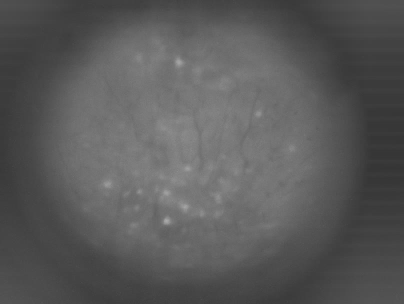

In [ ]:
# Visualize a couple of frames here for sanity check
import cv2
cap = cv2.VideoCapture(msFileList[0])
fps = cap.get(cv2.CAP_PROP_FPS)
print('FPS = '+ str(cap.get(cv2.CAP_PROP_FPS)))
while(cap.isOpened):
  ret, frame = cap.read()
  if(ret == True):
    cv2_imshow(frame)
  break


### **Downsample the Videos**

In [ ]:
for video in msFileList:
  clip = VideoFileClip(video)
  resized_clip = clip.resize(1/spatial_downsampling)
  os.remove(video)
  resized_clip.write_videofile(video,codec='rawvideo')

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam1.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam1.avi


100%|█████████▉| 1000/1001 [00:04<00:00, 224.26it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam1.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam2.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam2.avi


100%|█████████▉| 1000/1001 [00:04<00:00, 219.62it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam2.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam3.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam3.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 187.55it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam3.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam4.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam4.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 187.75it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam4.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam5.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam5.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 189.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam5.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam6.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam6.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 190.49it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam6.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam7.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam7.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 185.74it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam7.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam8.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam8.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 188.72it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam8.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam9.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam9.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 178.97it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam9.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam10.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam10.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 186.55it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam10.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam11.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam11.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 183.37it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam11.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam12.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam12.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 181.38it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam12.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam13.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam13.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 179.51it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam13.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam14.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam14.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 182.04it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam14.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam15.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam15.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 174.62it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam15.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam16.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam16.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 178.31it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam16.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam17.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam17.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 182.30it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam17.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam18.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam18.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 174.99it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam18.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam19.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam19.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 178.43it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam19.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam20.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam20.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 174.78it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam20.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam21.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam21.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 176.48it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam21.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam22.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam22.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 175.91it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam22.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam23.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam23.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 172.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam23.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam24.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam24.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 169.98it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam24.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam25.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam25.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 180.57it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam25.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam26.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam26.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 172.34it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam26.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam27.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam27.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 179.09it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam27.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam28.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam28.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 185.00it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam28.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam29.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam29.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 180.88it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam29.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam30.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam30.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 174.29it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam30.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam31.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam31.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 175.16it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam31.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam32.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam32.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 173.83it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam32.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam33.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam33.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 175.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam33.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam34.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam34.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 185.17it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam34.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam35.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam35.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 174.90it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam35.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam36.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam36.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 172.13it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam36.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam37.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam37.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 178.65it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam37.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam38.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam38.avi


100%|█████████▉| 1000/1001 [00:06<00:00, 161.94it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam38.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam39.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam39.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 172.79it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam39.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam40.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam40.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 174.96it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam40.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam41.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam41.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 177.14it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam41.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam42.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam42.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 175.79it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam42.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam43.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam43.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 175.84it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam43.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam44.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam44.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 179.20it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam44.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam45.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam45.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 171.18it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam45.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam46.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam46.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 182.67it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam46.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam47.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam47.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 186.29it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam47.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam48.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam48.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 178.80it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam48.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam49.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam49.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 177.87it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam49.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam50.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam50.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 183.56it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam50.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam51.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam51.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 177.80it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam51.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam52.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam52.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 177.04it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam52.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam53.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam53.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 169.18it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam53.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam54.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam54.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 179.46it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam54.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam55.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam55.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 178.51it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam55.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam56.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam56.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 170.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam56.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam57.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam57.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 176.01it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam57.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam58.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam58.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 172.31it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam58.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam59.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam59.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 176.82it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam59.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam60.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam60.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 175.92it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam60.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam61.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam61.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 180.44it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam61.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam62.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam62.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 176.48it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam62.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam63.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam63.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 177.96it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam63.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam64.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam64.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 176.21it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam64.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam65.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam65.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 190.25it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam65.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam66.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam66.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 172.91it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam66.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam67.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam67.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 173.04it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam67.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam68.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam68.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 171.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam68.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam69.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam69.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 170.37it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam69.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam70.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam70.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 167.86it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam70.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam71.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam71.avi


100%|█████████▉| 1000/1001 [00:06<00:00, 158.78it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam71.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam72.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam72.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 168.59it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam72.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam73.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam73.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 177.23it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam73.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam74.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam74.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 175.05it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam74.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam75.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam75.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 171.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam75.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam76.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam76.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 173.89it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam76.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam77.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam77.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 172.46it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam77.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam78.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam78.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 182.12it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam78.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam79.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam79.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 173.03it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam79.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam80.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam80.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 177.29it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam80.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam81.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam81.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 178.60it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam81.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam82.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam82.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 179.68it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam82.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam83.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam83.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 169.51it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam83.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam84.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam84.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 167.41it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam84.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam85.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam85.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 175.09it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam85.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam86.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam86.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 179.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam86.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam87.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam87.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 174.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam87.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam88.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam88.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 172.53it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam88.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam89.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam89.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 178.43it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam89.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam90.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam90.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 181.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam90.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam91.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam91.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 178.86it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam91.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam92.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam92.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 172.10it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam92.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam93.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam93.avi


100%|█████████▉| 1000/1001 [00:06<00:00, 160.13it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam93.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam94.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam94.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 177.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam94.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam95.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam95.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 175.46it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam95.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam96.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam96.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 170.81it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam96.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam97.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam97.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 176.64it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam97.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam98.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam98.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 180.20it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam98.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam99.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam99.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 183.39it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam99.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam100.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam100.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 178.48it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam100.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam101.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam101.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 176.74it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam101.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam102.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam102.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 173.94it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam102.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam103.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam103.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 175.09it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam103.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam104.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam104.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 174.32it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam104.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam105.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam105.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 181.17it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam105.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam106.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam106.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 169.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam106.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam107.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam107.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 167.55it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam107.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam108.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam108.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 176.25it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam108.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam109.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam109.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 176.88it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam109.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam110.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam110.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 173.28it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam110.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam111.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam111.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 180.59it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam111.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam112.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam112.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 182.32it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam112.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam113.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam113.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 174.54it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam113.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam114.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam114.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 177.85it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam114.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam115.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam115.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 177.58it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam115.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam116.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam116.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 181.92it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam116.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam117.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam117.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 170.23it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam117.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam118.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam118.avi


100%|█████████▉| 1000/1001 [00:13<00:00, 74.95it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam118.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam119.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam119.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 175.51it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam119.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam120.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam120.avi


100%|█████████▉| 1000/1001 [00:05<00:00, 178.57it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam120.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam121.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam121.avi


100%|█████████▉| 1000/1001 [00:07<00:00, 128.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam121.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam122.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam122.avi


100%|█████████▉| 1000/1001 [00:09<00:00, 111.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam122.avi 

[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam123.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam123.avi


100%|█████████▉| 1000/1001 [00:18<00:00, 54.12it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam123.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam124.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam124.avi


100%|█████████▉| 1000/1001 [00:21<00:00, 47.56it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam124.avi 



[MoviePy] >>>> Building video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam125.avi
[MoviePy] Writing video /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam125.avi


100%|█████████▉| 1000/1001 [00:19<00:00, 50.61it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam125.avi 



OSError: ignored

Text(0.5, 1.0, 'Downsampled size')

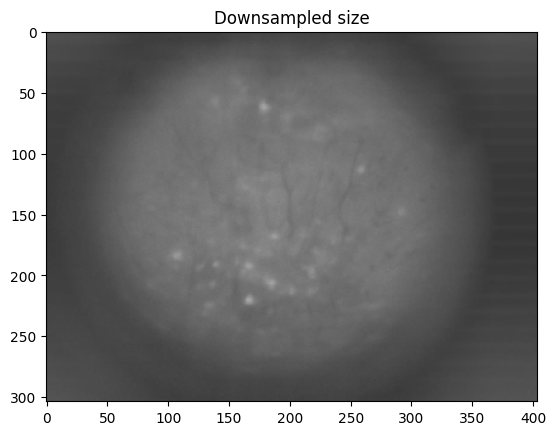

In [ ]:
# Make sure the video has been resized
clip = VideoFileClip(msFileList[0])
clip.save_frame(dirExperimentName + '/' + 'downsampled_frame.png')

img=mpl.image.imread(dirExperimentName + '/' + 'downsampled_frame.png')
imgplot = plt.imshow(img); plt.title('Downsampled size')

In [ ]:
fnames = msFileList
print(fnames)

['/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam1.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam2.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam3.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam4.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam5.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam6.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam7.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam8.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam9.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam10.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam11.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam12.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam13.avi', '/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/

In [ ]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

In [ ]:
for file in os.listdir(path_to_analyze):
  if(file.endswith('.dat') != True and file.endswith('avi') != True):
    try:
      print(path_to_analyze+'/' + str(file))
      os.remove(path_to_analyze+'/' + str(file))
    except:
      pass

/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/.ipynb_checkpoints
/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam1_rig__d1_304_d2_404_d3_1_order_F_frames_1000_.mmap
/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam2_rig__d1_304_d2_404_d3_1_order_F_frames_1000_.mmap
/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam3_rig__d1_304_d2_404_d3_1_order_F_frames_1000_.mmap
/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam4_rig__d1_304_d2_404_d3_1_order_F_frames_1000_.mmap
/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam5_rig__d1_304_d2_404_d3_1_order_F_frames_1000_.mmap
/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam6_rig__d1_304_d2_404_d3_1_order_F_frames_1000_.mmap
/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam7_rig__d1_304_d2_404_d3_1_order_F_frames_1000_.mmap
/content/gdrive/My Drive/H8_M55_S48 PP213-1/Cleaned_msCam/msCam8_rig__d1_304_d2_404_d3_1_order_F_frames_1000_.mmap
/co

Set Parameters for Motion Correction


In [ ]:
# dataset dependent parameters
frate = 20                       # movie frame rate
decay_time = 0.4                 # length of a typical transient in seconds

# motion correction parameters
motion_correct = True    # flag for performing motion correction
pw_rigid = False         # flag for performing piecewise-rigid motion correction (otherwise just rigid)
gSig_filt = (3, 3)       # size of high pass spatial filtering, used in 1p data
max_shifts = (5, 5)      # maximum allowed rigid shift
strides = (24, 24)       # start a new patch for pw-rigid motion correction every x pixels
overlaps = (12, 12)      # overlap between patches (size of patch strides+overlaps)
max_deviation_rigid = 3  # maximum deviation allowed for patch with respect to rigid shifts
border_nan = 'copy'      # replicate values along the boundaries
use_cuda = True         # Set to True in order to use GPU
only_init_patch = True
memory_fact = 0.8

mc_dict = {
    #'fnames': fnames,
    'fr': frate,
    'niter_rig': 1,
    'splits_rig': 20,  # for parallelization split the movies in  num_splits chuncks across time
    # if none all the splits are processed and the movie is saved
    'num_splits_to_process_rig': None, # intervals at which patches are laid out for motion correction            
    'decay_time': decay_time,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': border_nan,
    'use_cuda' : use_cuda,
    'only_init_patch' : only_init_patch,
    'memory_fact': memory_fact
}

opts = params.CNMFParams(params_dict=mc_dict)

Perform motion correction (might take a while)

In [ ]:
start = time.time() # This is to keep track of how long the analysis is running
if motion_correct:
    # do motion correction rigid
    mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
    mc.motion_correct(save_movie=True)
    fname_mc = mc.fname_tot_els if pw_rigid else mc.fname_tot_rig
    
end = time.time()

print(end - start)
print('Motion correction has been done!')

4897.967100858688
Motion correction has been done!


# Plot the motion corrected template and associated shifts


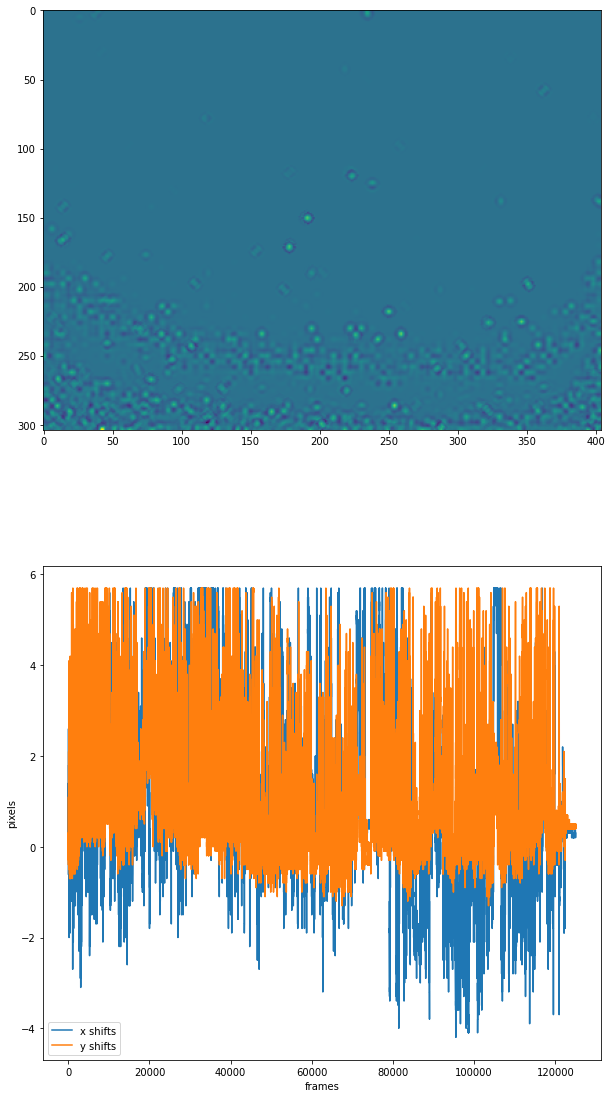

In [ ]:
%matplotlib inline
if motion_correct and not pw_rigid:
  plt.figure(figsize=(10,20))
  plt.subplot(2, 1, 1); plt.imshow(mc.total_template_rig);  # % plot template
  plt.subplot(2, 1, 2); plt.plot(mc.shifts_rig)  # % plot rigid shifts
  plt.legend(['x shifts', 'y shifts'])
  plt.xlabel('frames')
  plt.ylabel('pixels')

# Map the motion corrected video to memory

---

In [ ]:
if motion_correct:  
    if pw_rigid:
        bord_px = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                     np.max(np.abs(mc.y_shifts_els)))).astype(np.int)
    else:
        bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)

    bord_px = 0 if border_nan is 'copy' else bord_px
    fname_new = cm.save_memmap(fname_mc, base_name='memmap_', order='C',
                               border_to_0=bord_px)
    
else:  # if no motion correction just memory map the file
    fname_new = cm.save_memmap(fnames, base_name='memmap_',
                               order='C', border_to_0=0, dview=dview)
    
print('Motion corrected video has been mapped to memory')

In [ ]:
# load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
images = Yr.T.reshape((T,) + dims, order='F')

In [ ]:
#%% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

# Perform a projection of correlated pixels (and associated signal-to-noise ratio) in motion corrected video
This is important to assess the amounts of local correlations and peak-to-noise ratio as well as seed/initialize CNMFe


In [ ]:
# Compute some summary images (correlation and peak to noise) while downsampling temporally 5x to speedup the process and avoid memory overflow
cn_filter, pnr = cm.summary_images.correlation_pnr(images[::5], gSig=3, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile

In [ ]:
#Plot the results of the correlation/PNR projection
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1); plt.imshow(cn_filter); plt.colorbar(); plt.title('Correlation projection')
plt.subplot(2, 2, 2); plt.imshow(pnr); plt.colorbar(); plt.title('PNR')

In [ ]:
# Parameters for source extraction and deconvolution
p = 1               # order of the autoregressive system
K = None            # upper bound on number of components per patch, in general None
gSig = (3, 3)       # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = (15, 15)     # average diameter of a neuron, in general 4*gSig+1
Ain = None          # possibility to seed with predetermined binary masks
merge_thr = .65     # merging threshold, max correlation allowed
rf = 40             # half-size of the patches in pixels. e.g., if rf=40, patches are 80x80
stride_cnmf = 20    # amount of overlap between the patches in pixels
#                     (keep it at least large as gSiz, i.e 4 times the neuron size gSig)
tsub = 1            # downsampling factor in time for initialization,
#                     increase if you have memory problems
ssub = 1            # downsampling factor in space for initialization,
#                     increase if you have memory problems
#                     you can pass them here as boolean vectors
low_rank_background = None  # None leaves background of each patch intact,
#                     True performs global low-rank approximation if gnb>0
gnb = 1             # number of background components (rank) if positive,
#                     else exact ring model with following settings
#                         gnb= 0: Return background as b and W
#                         gnb=-1: Return full rank background B
#                         gnb<-1: Don't return background
nb_patch = 0        # number of background components (rank) per patch if gnb>0,
#                     else it is set automatically
min_corr = .8      # min peak value from correlation image
min_pnr = 8        # min peak to noise ration from PNR image
ssub_B = 2          # additional downsampling factor in space for background
ring_size_factor = 1.4  # radius of ring is gSiz*ring_size_factor
memory_fact = 0.8 # How much memory to allocate. 1 works for 16Gb, so 0.8 show be optimized for 12Gb.

opts.change_params(params_dict={'method_init': 'corr_pnr',  # use this for 1 photon
                                'K': K,
                                'gSig': gSig,
                                'gSiz': gSiz,
                                'merge_thr': merge_thr,
                                'p': p,
                                'tsub': tsub,
                                'ssub': ssub,
                                'rf': rf,
                                'stride': stride_cnmf,
                                'only_init': True,    # set it to True to run CNMF-E
                                'nb': gnb,
                                'nb_patch': nb_patch,
                                'method_deconvolution': 'oasis',       # could use 'cvxpy' alternatively
                                'low_rank_background': low_rank_background,
                                'update_background_components': True,  # sometimes setting to False improve the results
                                'min_corr': min_corr,
                                'min_pnr': min_pnr,
                                'normalize_init': False,               # just leave as is
                                'center_psf': True,                    # leave as is for 1 photon
                                'ssub_B': ssub_B,
                                'memory_fact': memory_fact,
                                'ring_size_factor': ring_size_factor,
                                'del_duplicates': True,                # whether to remove duplicates from initialization
                                'border_pix': bord_px})                # number of pixels to not consider in the borders)

# Perform CNMFe extraction
This will take a while. Coffee time!

In [ ]:
start = time.time()
# Perform CNMF
cnm = cnmf.CNMF(n_processes=n_processes, dview=dview, Ain=Ain, params=opts)
cnm.fit(images)

end = time.time()
print(end - start)

# Evaluate components

In [ ]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

min_SNR = 3            # adaptive way to set threshold on the transient size
r_values_min = 0.85    # threshold on space consistency (if you lower more components
#                        will be accepted, potentially with worst quality)
cnm.params.set('quality', {'min_SNR': min_SNR,
                           'rval_thr': r_values_min,
                           'use_cnn': False})
cnm.estimates.evaluate_components(images, cnm.params, dview=dview)

print(' ***** ')
print('Number of total components: ', len(cnm.estimates.C))
print('Number of accepted components: ', len(cnm.estimates.idx_components))

# Plot the results for inspection

In [ ]:
%matplotlib inline

#How many neurons to plot
neuronsToPlot = 20

DeconvTraces = cnm.estimates.S
RawTraces = cnm.estimates.C
SFP = cnm.estimates.A
SFP_dims = list(dims)
SFP_dims.append(SFP.shape[1]) 
print('Spatial foootprints dimensions (height x width x neurons): ' + str(SFP_dims))

numNeurons = SFP_dims[2]

SFP = np.reshape(SFP.toarray(), SFP_dims, order='F')

maxRawTraces = np.amax(RawTraces)

plt.figure(figsize=(30,15))
plt.subplot(341);
plt.subplot(345); plt.plot(mc.shifts_rig); plt.title('Motion corrected shifts')
plt.subplot(3,4,9);
plt.subplot(3,4,2); plt.imshow(cn_filter); plt.colorbar(); plt.title('Correlation projection')
plt.subplot(3,4,6); plt.imshow(pnr); plt.colorbar(); plt.title('PNR')
plt.subplot(3,4,10); plt.imshow(np.amax(SFP,axis=2)); plt.colorbar(); plt.title('Spatial footprints')

plt.subplot(2,2,2); plt.figure; plt.title('Example traces (first 50 cells)')
plot_gain = 10 # To change the value gain of traces
if numNeurons >= neuronsToPlot:
  for i in range(neuronsToPlot):
    if i == 0:
      plt.plot(RawTraces[i,:],'k')
    else:
      trace = RawTraces[i,:] + maxRawTraces*i/plot_gain
      plt.plot(trace,'k')
else:
  for i in range(numNeurons):
    if i == 0:
      plt.plot(RawTraces[i,:],'k')
    else:
      trace = RawTraces[i,:] + maxRawTraces*i/plot_gain
      plt.plot(trace,'k')

plt.subplot(2,2,4); plt.figure; plt.title('Deconvolved traces (first 50 cells)')
plot_gain = 20 # To change the value gain of traces
if numNeurons >= neuronsToPlot:
  for i in range(neuronsToPlot):
    if i == 0:
      plt.plot(DeconvTraces[i,:],'k')
    else:
      trace = DeconvTraces[i,:] + maxRawTraces*i/plot_gain
      plt.plot(trace,'k')
else:
  for i in range(numNeurons):
    if i == 0:
      plt.plot(DeconvTraces[i,:],'k')
    else:
      trace = DeconvTraces[i,:] + maxRawTraces*i/plot_gain
      plt.plot(trace,'k')      

# Save summary figure
plt.savefig(dirExperimentName + '/' + 'summary_figure.svg', edgecolor='w', format='svg', transparent=True)

# Register the timestamps for analysis


In [ ]:

with open(path + '/timestamp.dat') as f:
  camNum, frameNum, sysClock, buffer = np.loadtxt(f, dtype='float', comments='#', skiprows=1, unpack = True)
  
cameraMatched = False
for j in range(int(max(camNum))+1):
  if sum(camNum==j) != 0:
    camFrameList, = np.where(camNum == j)
    camLastFrame = camFrameList[-1]
    LastFrame = frameNum[camLastFrame]
    if (sum(camNum==j) == len(RawTraces[1])) and (LastFrame == len(RawTraces[1])):
      camNumber = j
      mstime_idx = np.where(camNum == j)
      mstime=sysClock[mstime_idx]
      mstime[0] = 0
      maxBufferUsed = max(buffer[mstime_idx])
      cameraMatched = True
      
if cameraMatched is not True:
  print('Problem matching up timestamps for ' + experimentName)
else:
  print('Successfully registered timestamps for ' + experimentName)

In [ ]:
# Stop counter and register analysis time
analysis_end = time.time()

analysis_duration = analysis_end - analysis_start

print('Done analyzing. This took a total ' + str(analysis_duration) + ' s')

# Save the results in HDF5 format

In [ ]:
if save_hdf5: 
  cnm.save(dirExperimentName + '/analysis_results.hdf5')

# Save the results in Matlab format


In [ ]:
if save_mat:
  from scipy.io import savemat
  
  results_dict = {
                'dirName': path_to_analyze,
                'numFiles': len(msFileList),
                'framesNum': len(RawTraces[1]),
                'maxFramesPerFile': 1000,
                'height': dims[0],
                'width': dims[1],
                'Experiment': experimentName,
                'ExperimentTimestamp': experiment_timestamp,
                'camNumber': 0,
                'time': mstime,
                'analysis_time': analysis_time,
                'ds': spatial_downsampling,
                'shifts': mc.shifts_rig,
                'meanFrame': [], #TO DO
                'Centroids': [], #TO DO
                'CorrProj': cn_filter,
                'PeakToNoiseProj': pnr,
                'FiltTraces': [], #TO DO
                'RawTraces': RawTraces.conj().transpose(), #swap time x neurons dimensions
                'SFP': SFP,
                'numNeurons': SFP_dims[2],
                'analysis_duration': analysis_duration
                }

  SFPperm = np.transpose(SFP,[2,0,1])
  sio.savemat(dirExperimentName + '/SFP.mat', {'SFP': SFPperm})
  sio.savemat(dirExperimentName + '/ms.mat', {'ms': results_dict})